# Tutorial 03: road compliance checking

The collision checker library provides a convenient way to construct the road boundary for a scenario and check if the vehicle is within the road.


## 1. Load the scenario
We import necessary modules and load the example scenario.

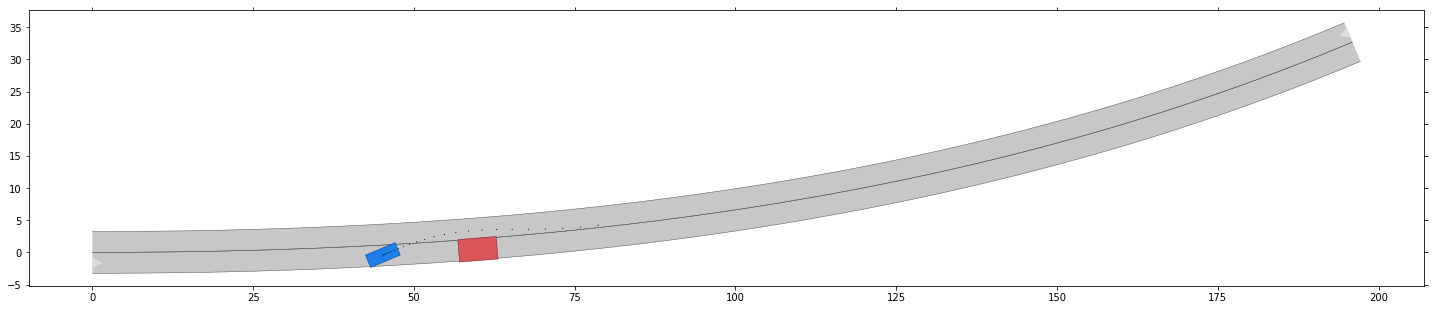

In [1]:
%matplotlib inline
from time import time

# commonroad
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

#commonroad_dc
from commonroad_dc.boundary import boundary
from commonroad_dc.collision.trajectory_queries import trajectory_queries
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker
import commonroad_dc.pycrcc as pycrcc
from commonroad_dc.pycrcc.Util import trajectory_enclosure_polygons_static


def open_scenario(scenario_filename):
    crfr = CommonRoadFileReader(
        scenario_filename)
    scenario, planning_problem_set = crfr.open()
    return scenario, planning_problem_set

#open the example scenario
scenario, planning_problem_set = open_scenario("Tut_compliance.xml")

# plot the scenario
rnd = MPRenderer(figsize=(25, 10))
scenario.draw(rnd)
planning_problem_set.draw(rnd)
rnd.render()


## 2. Build the road boundary

The drivability checker library provides several methods to check road compliance. In particular, methods for the following
two general approaches are implemented:
* **Road boundary collision check (see Section 2.1.)**: checks whether the ego vehicle trajectory collides with the boundary, which is approximated using simple shapes.
* **Occupancy inclusion (see Section 2.2.)**: checks whether the ego vehicle occupancy is included within the drivable road network for the entire trajectory.

Both approaches to check road compliance are complementary to each other. Our toolbox provides different methods for each approach,
which might differ in their performance.


### 2.1. Road Boundary Collision Check
Our toolbox offers multiple methods for approximating the road boundary of a given road network:
* Default method: **Oriented rectangles** (Sec. 2.1.1.)
* **Triangulation methods** (Sec. 2.1.2. - 2.1.4.)


### 2.1.1. Oriented Rectangles (recommended method)
This method uses oriented rectangles to approximate the road boundary. By default, no boundary is constructed at the lane endings (**open lane ends**). Note, that open lane ends are
only supported using the oriented rectangle method.

Computation time: 0.010097742080688477
Number of boundary elements: 396


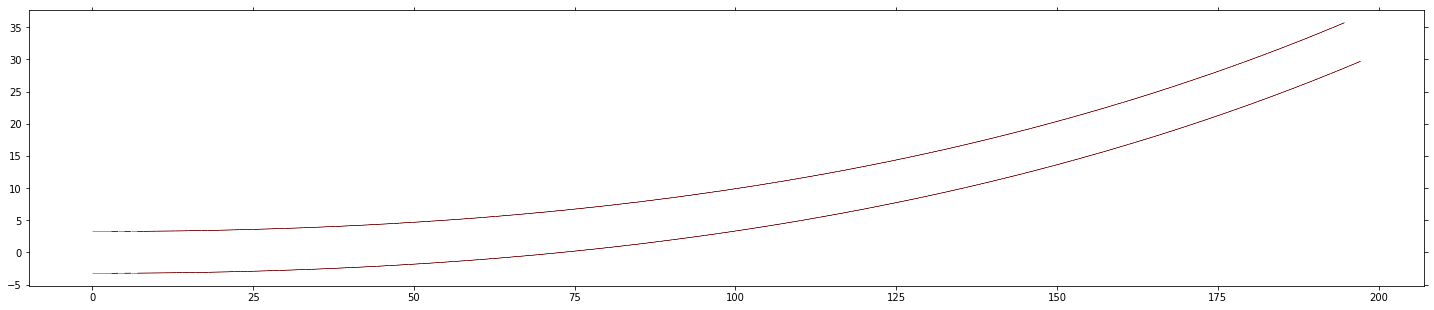

In [2]:
time1=time()
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario)
time2=time()

print("Computation time: %s" % (time2-time1))

rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_rectangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % road_boundary_sg_rectangles.size())


If, however,  a road boundary is desired at the lane endings, the parameter `open_lane_ends` can be set to `False` (see below):

Computation time: 0.040154218673706055
Number of boundary elements: 400


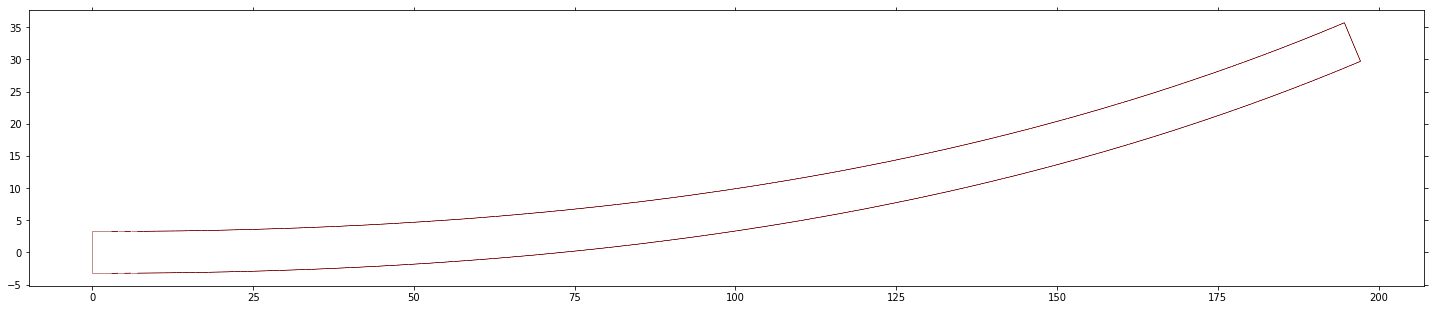

In [3]:
time1=time()
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles', open_lane_ends=False)
time2=time()

print("Computation time: %s" % (time2-time1))

rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_rectangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % road_boundary_sg_rectangles.size())


### 2.1.2. Delaunay Triangulation

Computation time: 0.5444240570068359
Number of boundary elements: 1161


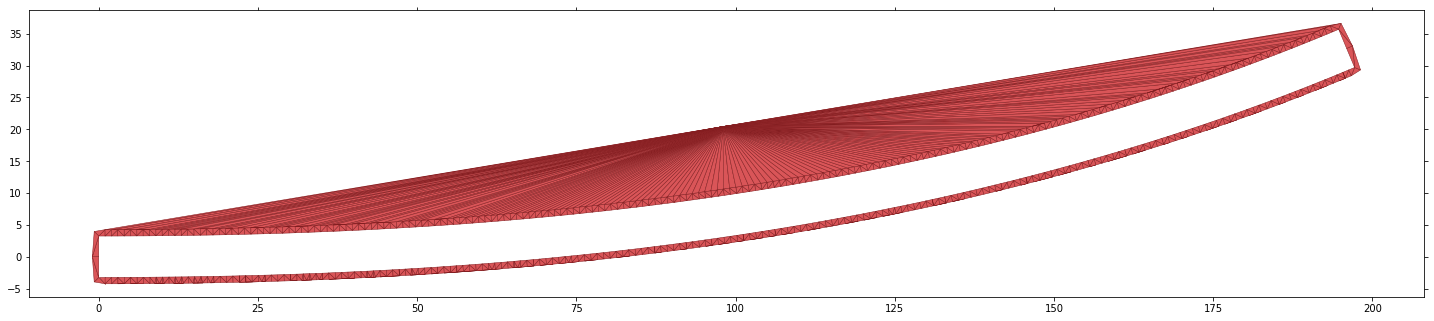

In [4]:
time1=time()
road_boundary_obstacle, road_boundary_sg_triangles=boundary.create_road_boundary_obstacle(scenario, method='triangulation')
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_triangles.draw(rnd)
rnd.render()
print("Number of boundary elements: %s" % road_boundary_sg_triangles.size())


### 2.1.3. Axis-Aligned Triangles (Horizontal)

Computation time: 0.31572747230529785
Number of boundary elements: 920


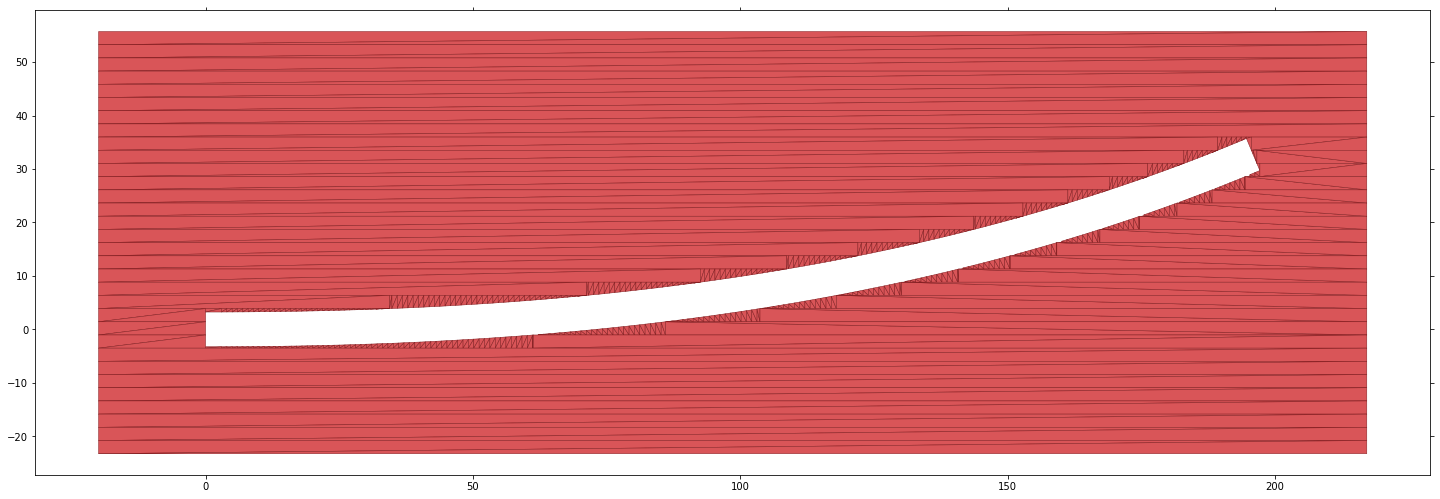

In [5]:
time1=time()
road_boundary_obstacle, road_boundary_sg_aligned_triangles=boundary.create_road_boundary_obstacle(scenario, method='aligned_triangulation', axis=1)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_aligned_triangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % road_boundary_sg_aligned_triangles.size())


### 2.1.4. Axis-Aligned Triangles (Vertical)

Computation time: 0.39363908767700195
Number of boundary elements: 960


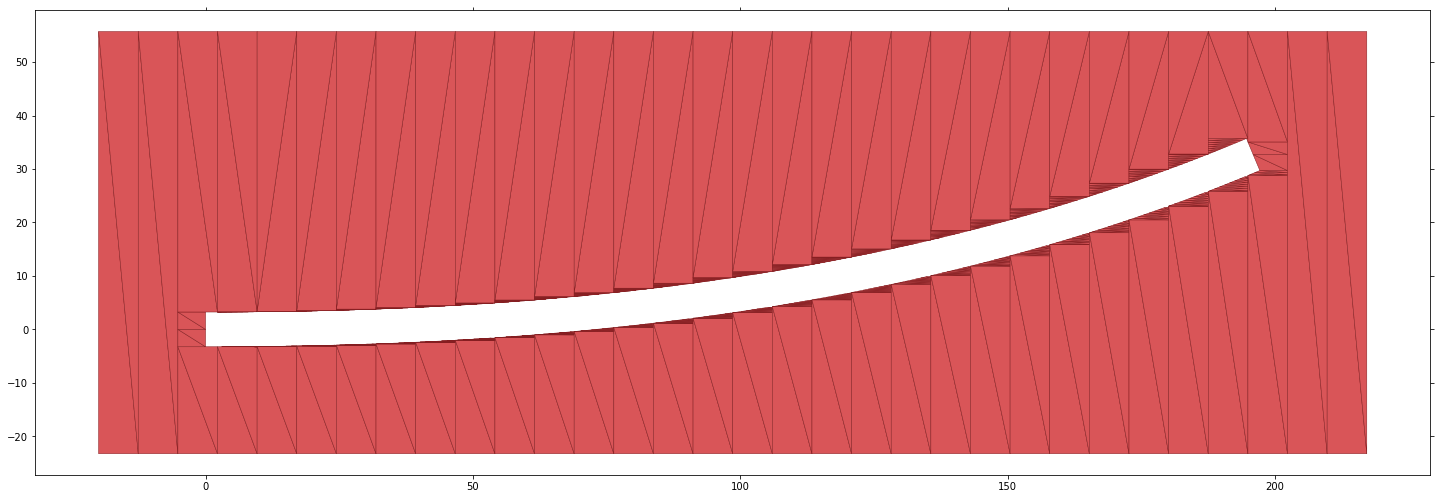

In [6]:
time1=time()
road_boundary_obstacle, road_boundary_sg_aligned_triangles=boundary.create_road_boundary_obstacle(scenario, method='aligned_triangulation', axis=2)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_aligned_triangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % road_boundary_sg_aligned_triangles.size())



## 2.2. Occupancy Inclusion
The occupancy inclusion approach represents the drivable road network by a set of polygons. Four different methods are
available to construct the polygons. The method is chosen by setting the parameter `method` accordingly in the function
`boundary.create_road_polygons`.

### 2.2.1. Lane Polygons

Computation time: 0.005386829376220703


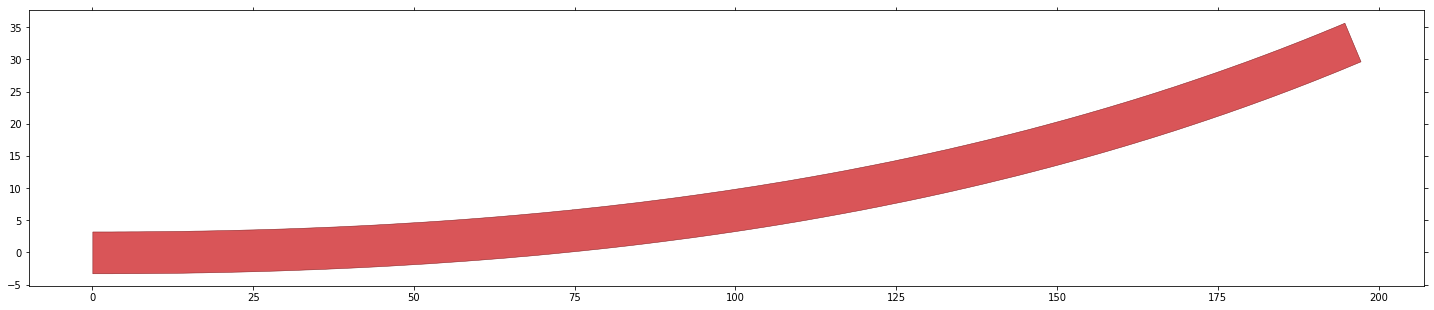

In [7]:
time1=time()
road_boundary_sg_polygons=boundary.create_road_polygons(scenario, method='lane_polygons',buffer=1,resample=1, triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons.draw(rnd, draw_params={'draw_mesh': False})
rnd.render()


### 2.2.2. Lanelet Polygons
Lanelet Polygons (in contrast to Lane Polygons) construct a polygon for each seperate lanelet in the road network. In this
example scenario two polygons are constructed corresponding to the two lanelets.

Computation time: 0.009837150573730469


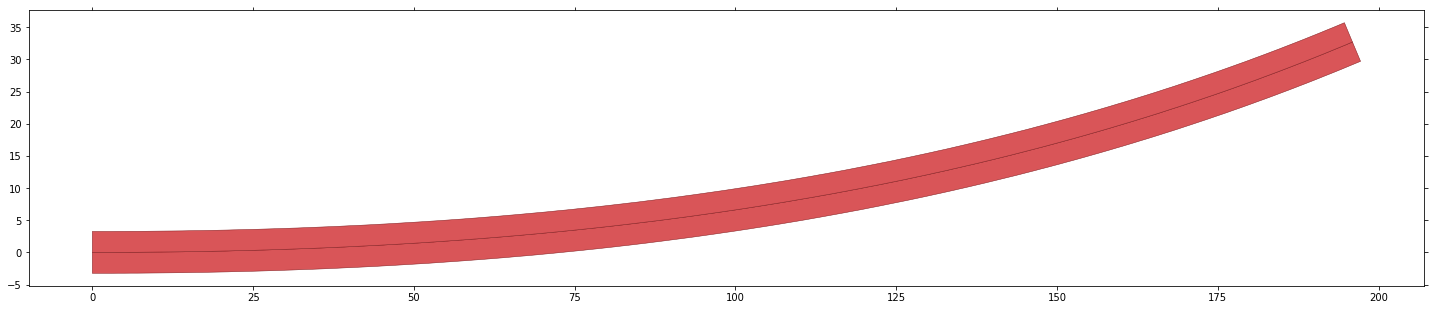

In [8]:
time1=time()
road_boundary_sg_polygons =boundary.create_road_polygons(scenario, method='lanelet_polygons', buffer=1,resample=1, triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons.draw(rnd, draw_params={'draw_mesh': False})
rnd.render()

### 2.2.3. Polygons with Holes (Grid)

Computation time: 0.018402576446533203


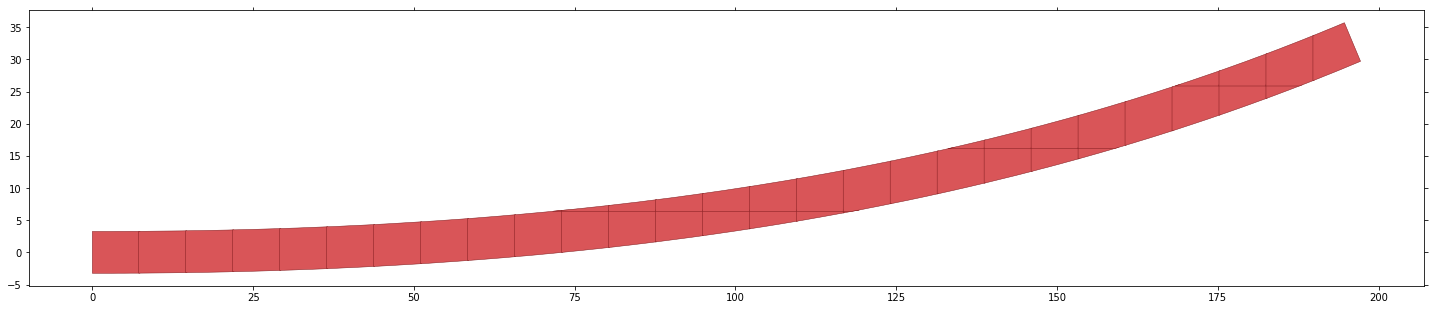

In [9]:
# length of the ego-vehicle
car_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# width of the ego-vehicle
car_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

time1=time()
road_boundary_sg_polygons_grid=boundary.create_road_polygons(scenario, method='whole_polygon_tiled', max_cell_width=car_half_length*3, max_cell_height=car_half_length*5,triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons_grid.draw(rnd, draw_params={'draw_mesh': False})
rnd.render()

### 2.2.4. Polygons with Holes

Computation time: 0.000820159912109375


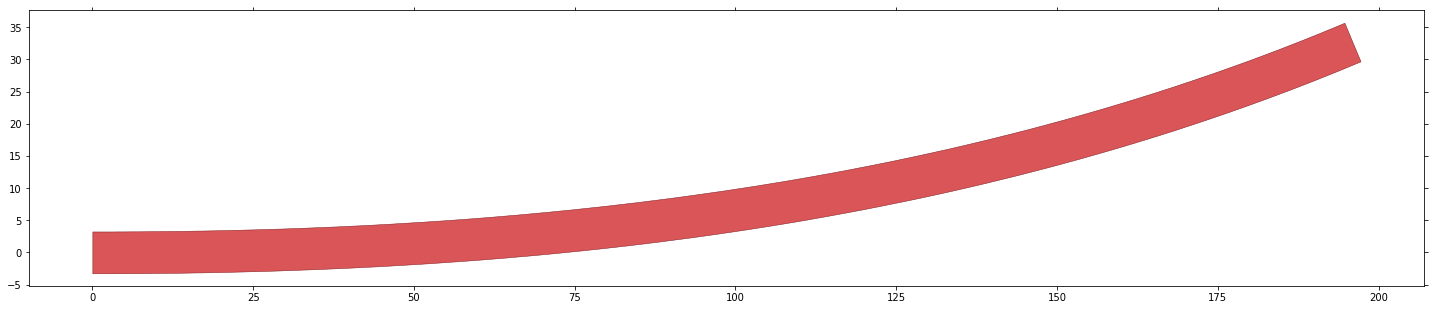

In [10]:
time1=time()
road_boundary_sg_polygons=boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons.draw(rnd, draw_params={'draw_mesh': False})
rnd.render()

## 3. Usage Example: Check if the trajectory is within the road

After constructing a road boundary, we can check whether a given trajectory is road-compliant.

### 3.1. Select part of the trajectory for compliance checks

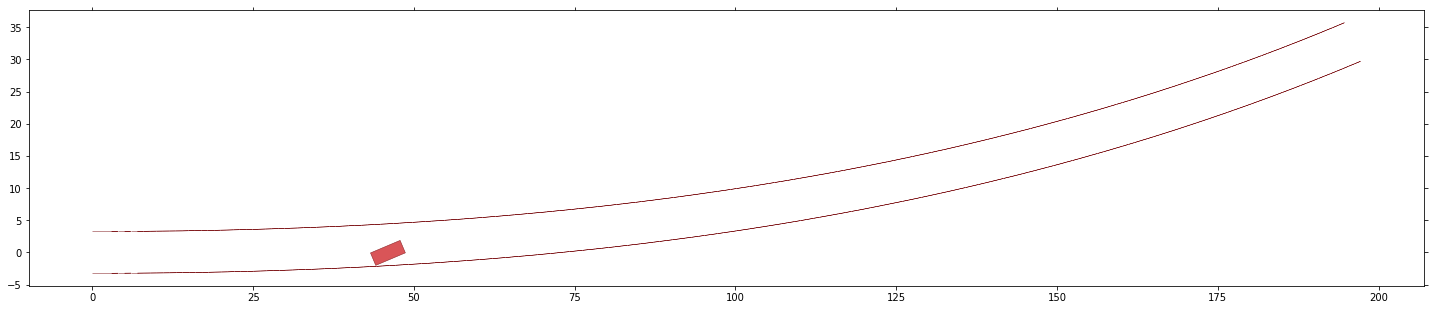

In [11]:
start_step=3

# half-length of the ego-vehicle
car_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# half-width of the ego-vehicle
car_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

# list with trajectory states that are checked for collisions with the road boundary
traj_list=list()
state_list=scenario.dynamic_obstacles[0].prediction.trajectory.state_list

# extract the positions (x,y) and orientation of the state list and store them in traj_list
for el in state_list[start_step:]:
    new_el=list()
    new_el.append(el.position[0])   # position x
    new_el.append(el.position[1])   # position y
    new_el.append(el.orientation)   # orientation
    traj_list.append(new_el)
    
# create an oriented rectangle (RectOBB) for the ego vehicle at Step i of the traj_list
i=0
obb=pycrcc.RectOBB(car_half_length, car_half_width, traj_list[i][2],traj_list[i][0],traj_list[i][1])

# create the road boundary (using default method with oriented rectangles) and draw the scenario at at time step i
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario)
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_rectangles.draw(rnd)
obb.draw(rnd)
rnd.render()


We create a time-variant collision object for the ego vehicle.

In [12]:
def create_tvobstacle(traj_list,car_half_length,car_half_width):
    tvo=pycrcc.TimeVariantCollisionObject(0)
    for traj in traj_list:
        tvo.append_obstacle(pycrcc.RectOBB(car_half_length, car_half_width, traj[2],traj[0],traj[1]))
    return tvo

co=create_tvobstacle(traj_list,car_half_length,car_half_width)


Next, we preprocess the time-variant collision object (ego vehicle) for **continuous collision detection**: We construct an oriented bounding box (OBB)
around the occupancies for two consecutive time steps. **NOTE**: The trajectory of the resulting time-variant collision object is one time step
smaller than the original trajectory.

In [13]:
# preprocess using OBB sum hull
preprocessed_trajectory, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
if(err):
    raise Exception("trajectory preprocessing error")


We can then check whether the trajectories are compliant to the road network using the approaches described above:

### Approach 1: Road boundary collision checks

##### Simplified approach (only check if the trajectory collides with the road boundary)

In [14]:
# compute time step of collision with road boundary
ret=trajectory_queries.trajectories_collision_static_obstacles([preprocessed_trajectory], road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True)
if ret[0] == -1:
    print('No collision with the road boundary')
else:
    print('First time step of collision: %s' % ret[0])

No collision with the road boundary


##### Full approach (first check if the vehicle is within the road at the first time step, then check if the trajectory collides with the road boundary)

In [15]:
# compute time step of collision with road boundary using oriented rectangles

#check if the first time step of the trajectory is enclosed within the road polygon
if trajectory_enclosure_polygons_static(road_boundary_sg_polygons,car_half_length, car_half_width, traj_list[start_step:start_step+1])==-1:   
    # check if the trajectory collides with the OBB road boundary
    ret=trajectory_queries.trajectories_collision_static_obstacles([preprocessed_trajectory], road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True)
    if ret[0] == -1:
        print('The trajectory is fully within the road')
    else:
        print('First time step of collision: %s' % ret[0])
else:
    print('The trajectory is not within the road. At its first time step, the vehicle is outside the road.')

The trajectory is fully within the road


### Approach 2: Occupancy Inclusion

#### Polygons with holes (grid)

In [16]:
# check trajectory enclosure using road polygon
ret=trajectory_queries.trajectories_enclosure_polygons_static([preprocessed_trajectory], road_boundary_sg_polygons_grid, method='grid', num_cells=32, enable_verification=False)
if ret[0] == -1:
    print('The trajectory is completely enclosed')
else:
    print('First time step of incomplete enclosure: %s' % ret[0])


The trajectory is completely enclosed


## 4. Usage Example: Minkowski sum for road boundaries

As demonstrated in *Tutorial 02: CommonRoad Interface*, our toolbox allows us to compute the minkowski sum with a circle
for any *commonroad-io* shape. The same can be done for the road boundary obstacle when using approach 1 for road compliance
checking. As shown below, we can inflate the road boundary obstacle which corresponds to specifying a safety distance
the vehicle should keep to the road boundary.


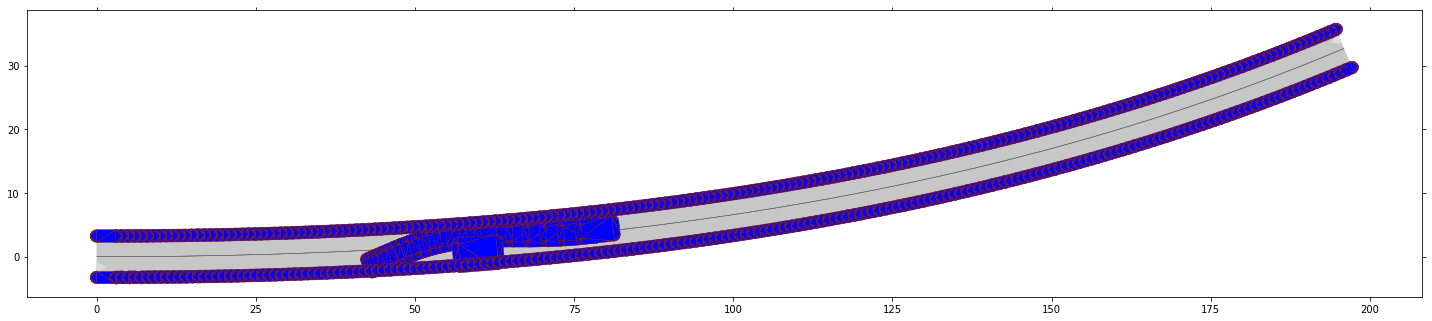

In [17]:
# create road boundary obstacle (default method with oriented rectangles)
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario)

# add road boundary as static obstacle to scenario
scenario.add_objects(road_boundary_obstacle)

# create collision checker for scenario
cc = create_collision_checker(scenario, params={'minkowski_sum_circle': True,
                                                'minkowski_sum_circle_radius': 1.0,
                                                'resolution': 4})

# visualize scenario and collision objects
rnd = MPRenderer(figsize=(25, 10))
scenario.lanelet_network.draw(rnd)
cc.draw(rnd, draw_params={'facecolor': 'blue', 'draw_mesh': True})
rnd.render()